# Downloading CrisisMMD dataset

In [1]:
!wget https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz
!tar -xvf CrisisMMD_v2.0.tar.gz
!mv CrisisMMD_v2.0/data_image $PWD/

Streaming output truncated to the last 5000 lines.
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909492601702813697_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909386917179006978_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909395308890804229_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909427065774108672_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909394515441668097_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909451477944594434_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909434397077753861_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909484367117934594_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909472166340476928_2.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909423709588398081_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909461680178032641_0.jpg
CrisisMMD_v2.0/data_image/hurricane_irma/17_9_2017/909472166340476928_3.jpg
CrisisMMD_v2.0/data_image/hurricane_i

In [2]:
!unzip /content/CrisisMMD_v2.0/crisismmd_datasplit_all.zip -d /content/crisismmd_datasplit_all

Archive:  /content/CrisisMMD_v2.0/crisismmd_datasplit_all.zip
  inflating: /content/crisismmd_datasplit_all/task_informative_text_img_train.tsv  
   creating: /content/crisismmd_datasplit_all/__MACOSX/
  inflating: /content/crisismmd_datasplit_all/__MACOSX/._task_informative_text_img_train.tsv  
  inflating: /content/crisismmd_datasplit_all/task_informative_text_img_test.tsv  
  inflating: /content/crisismmd_datasplit_all/task_informative_text_img_dev.tsv  
  inflating: /content/crisismmd_datasplit_all/task_humanitarian_text_img_test.tsv  
  inflating: /content/crisismmd_datasplit_all/task_humanitarian_text_img_dev.tsv  
  inflating: /content/crisismmd_datasplit_all/task_humanitarian_text_img_train.tsv  
  inflating: /content/crisismmd_datasplit_all/__MACOSX/._task_humanitarian_text_img_train.tsv  


#Loading CSV as dataframe with train, validation, test splits

In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('/content/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
dev = pd.read_csv('/content/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')
test = pd.read_csv('/content/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t')

In [5]:
display(train.head())

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
1,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_informative,informative,not_informative,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive


In [6]:
print(train.shape,dev.shape,test.shape)

(13608, 9) (2237, 9) (2237, 9)


In [7]:
train['tweet_text'][0]

'RT @Cal_OES: PLS SHARE: Weâ€™re capturing wildfire response, recovery info here: https://t.co/r89LKpjLPj https://t.co/HiA1oQF2Ax'

# Data pre-processing/cleaning



### Task_1-Text

In [8]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 34.4MB/s 
     |████████████████████████████████| 901kB 56.7MB/s 


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import random

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score

seed_val = 2
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def remove_URL(tweet):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', tweet) 

def remove_emoji(tweet):
  emoji_pattern = re.compile(
      '['
        u'\U0001F600-\U0001F64F'  
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
  )
  return emoji_pattern.sub(r'', tweet)

def remove_html(tweet):
  html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  return re.sub(html, '', tweet)

def remove_punctuation(tweet):
  table = str.maketrans('', '', string.punctuation)
  return tweet.translate(table)

def clean_unicode(tweet):
  tweet.encode('ascii', 'ignore').strip() 

#clean training dataset
train['clean_tweet'] = train['tweet_text'].apply(lambda x: remove_URL(x))
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: remove_emoji(x))
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: remove_html(x))
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: remove_punctuation(x))
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())


#clean dev dataset
dev['clean_tweet'] = dev['tweet_text'].apply(lambda x: remove_URL(x))
dev['clean_tweet'] = dev['clean_tweet'].apply(lambda x: remove_emoji(x))
dev['clean_tweet'] = dev['clean_tweet'].apply(lambda x: remove_html(x))
dev['clean_tweet'] = dev['clean_tweet'].apply(lambda x: remove_punctuation(x))
dev['clean_tweet'] = dev['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

#clean test dataset
test['clean_tweet'] = test['tweet_text'].apply(lambda x: remove_URL(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: remove_emoji(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: remove_html(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: remove_punctuation(x))
test['clean_tweet'] = test['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

In [11]:
print(train['clean_tweet'][0])
print(dev['clean_tweet'][0])
print(test['clean_tweet'][0])

RT CalOES PLS SHARE Were capturing wildfire response recovery info here
Iran earthquake damage put at over 5bn pounds  International PaoloGentiloni
Cristofer CLEMENTE MORA now in 2nd at aguille du posettes Hes hunting  MontBlancMarathon 80k


In [12]:
#tokenize
train['tokenized_tweet'] = train['clean_tweet'].apply(word_tokenize)
dev['tokenized_tweet'] = dev['clean_tweet'].apply(word_tokenize)
test['tokenized_tweet'] = test['clean_tweet'].apply(word_tokenize)

print(train['tokenized_tweet'][0])
print(dev['tokenized_tweet'][0])
print(test['tokenized_tweet'][0])

['RT', 'CalOES', 'PLS', 'SHARE', 'Were', 'capturing', 'wildfire', 'response', 'recovery', 'info', 'here']
['Iran', 'earthquake', 'damage', 'put', 'at', 'over', '5bn', 'pounds', 'International', 'PaoloGentiloni']
['Cristofer', 'CLEMENTE', 'MORA', 'now', 'in', '2nd', 'at', 'aguille', 'du', 'posettes', 'Hes', 'hunting', 'MontBlancMarathon', '80k']


In [13]:
train['lower'] = train['tokenized_tweet'].apply(
    lambda x : [word.lower() for word in x]
)

dev['lower'] = dev['tokenized_tweet'].apply(
    lambda x : [word.lower() for word in x]
)

test['lower'] = test['tokenized_tweet'].apply(
    lambda x : [word.lower() for word in x]
)

train['stopword_removed'] = train['lower'].apply(
    lambda x : [word for word in x if word not in stop_words]
)

dev['stopword_removed'] = dev['lower'].apply(
    lambda x : [word for word in x if word not in stop_words]
)

test['stopword_removed'] = test['lower'].apply(
    lambda x : [word for word in x if word not in stop_words]
)

In [14]:
train['stopword_removed'][0]

['rt',
 'caloes',
 'pls',
 'share',
 'capturing',
 'wildfire',
 'response',
 'recovery',
 'info']

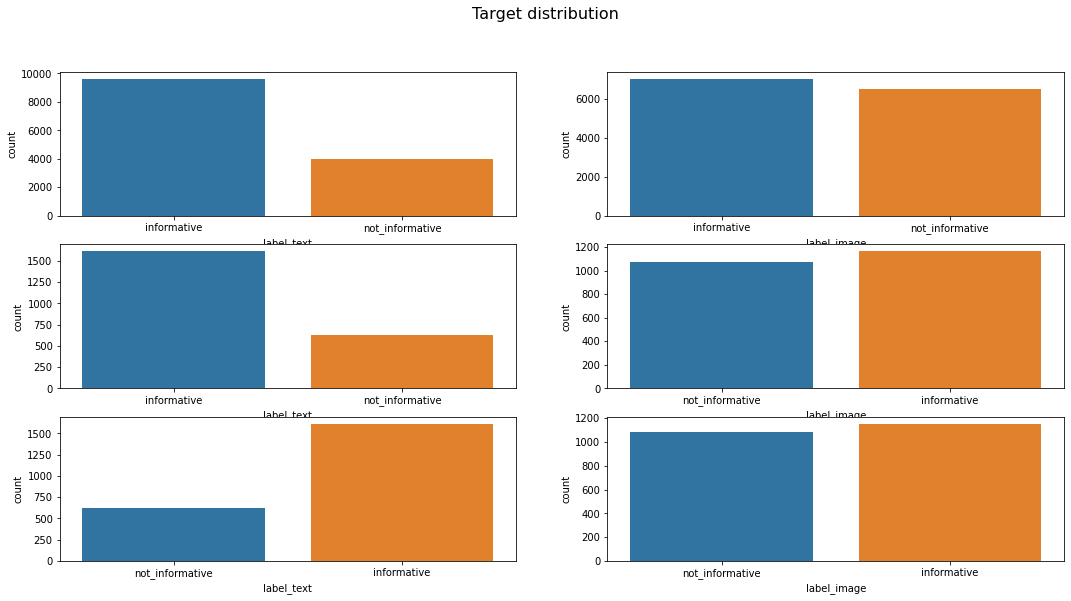

In [15]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize=(18,9))
sns.countplot(x = train['label_text'], ax = axes[0,0])
sns.countplot(x = train['label_image'], ax = axes[0,1])
sns.countplot(x = dev['label_text'], ax = axes[1,0])
sns.countplot(x = dev['label_image'], ax = axes[1,1])
sns.countplot(x = test['label_text'], ax = axes[2,0])
sns.countplot(x = test['label_image'], ax = axes[2,1])

fig.suptitle("Target distribution", fontsize=16)

plt.show()

In [16]:
#word count
def plot_word_count(informative, not_informative):
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,4), sharey=True)
  sns.histplot(informative.str.split().map(
      lambda x: len(x)), ax = axes[0]
  )

  sns.histplot(not_informative.str.split().map(
      lambda x: len(x)), ax = axes[1]
  )

  axes[0].set_xlabel('Word Count')
  axes[0].set_ylabel('Frequency')
  axes[0].set_title('Informative')
  axes[1].set_xlabel('Word Count')
  axes[1].set_title('Not Informative')

  fig.suptitle("Words per tweet", fontsize=24, va='baseline')

  fig.tight_layout()

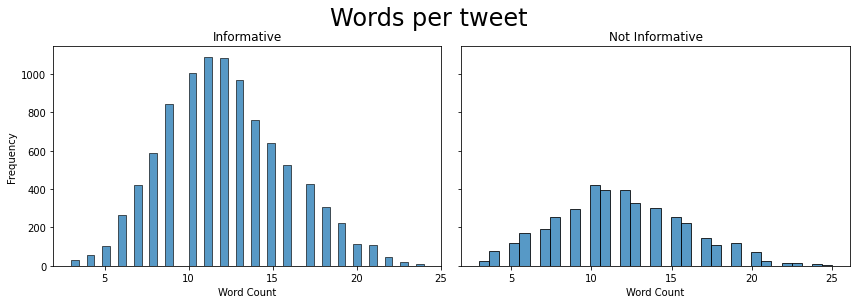

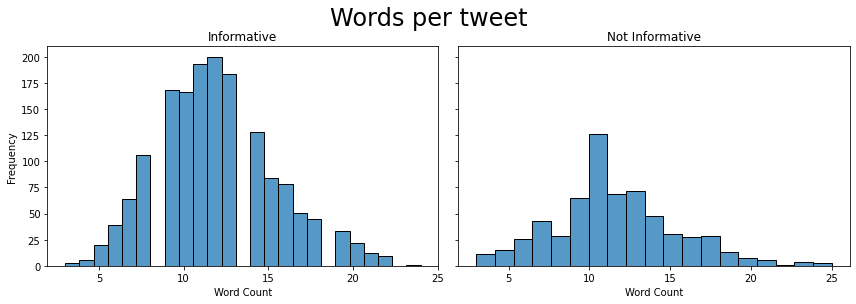

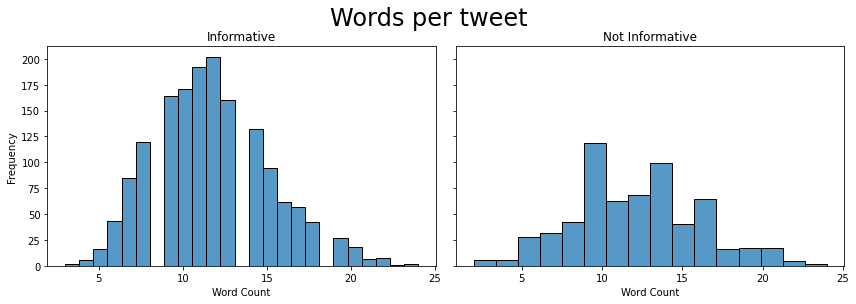

In [17]:
plot_word_count(train[train['label_text'] == 'informative']['clean_tweet'], train[train['label_text'] == 'not_informative']['clean_tweet'])
plot_word_count(dev[dev['label_text'] == 'informative']['clean_tweet'], dev[dev['label_text'] == 'not_informative']['clean_tweet'])
plot_word_count(test[test['label_text'] == 'informative']['clean_tweet'], test[test['label_text'] == 'not_informative']['clean_tweet'])

# Task 1 Informative & Non Informative


### 1.   Part A: Text
### 2.   Part B: Image

## Part A: Text calssification Using Transformer

In [18]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else :
  device = torch.device('cpu')
  print("GPU not available")

torch.cuda.empty_cache()

Tesla T4


In [19]:
diction = {'informative': 1, 'not_informative': 0}
train['label_text'] = [diction[item] for item in train['label_text']]
dev['label_text'] = [diction[item] for item in dev['label_text']]
test['label_text'] = [diction[item] for item in test['label_text']]

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [23]:
print(train['clean_tweet'][0])
print(tokenizer.tokenize(train['clean_tweet'][0]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['clean_tweet'][0])))

RT CalOES PLS SHARE Were capturing wildfire response recovery info here
['rt', 'cal', '##oes', 'pl', '##s', 'share', 'were', 'capturing', 'wild', '##fire', 'response', 'recovery', 'info', 'here']
[19387, 10250, 22504, 20228, 2015, 3745, 2020, 11847, 3748, 10273, 3433, 7233, 18558, 2182]


In [24]:
def get_max_len(tweets):
  max_len = 0
  for tweet in tweets:
    input_ids = tokenizer.encode(tweet, add_special_tokens = True)
    max_len = max(max_len, len(input_ids))
  
  return max_len

print("Largest tweets in train, dev and test set")
print(get_max_len(train['clean_tweet']))
print(get_max_len(dev['clean_tweet']))
print(get_max_len(test['clean_tweet']))

Largest tweets in train, dev and test set
42
37
37


In [25]:
def tokenize(tweets, labels):
  input_ids = []
  attention_masks = []

  for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        truncation = 'longest_first',
        max_length = 42,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt' #pytorch tensors
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [26]:
input_ids, attention_masks, labels = tokenize(train['clean_tweet'].values, train['label_text'].values)
dev_input_ids, dev_attention_masks, dev_labels = tokenize(dev['clean_tweet'].values, dev['label_text'].values)

In [27]:
print(input_ids.shape)

torch.Size([13608, 42])


In [28]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)
dev_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

In [29]:
a = np.array(train['label_text']).astype(int)
sample_weights = np.array([0.25 , 0.75])
weights = sample_weights[a]
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights = weights, num_samples = len(train['label_text']),replacement = True)

In [30]:
# train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
train_dataloader = DataLoader(train_dataset, sampler = sampler, batch_size = 64)
dev_dataloader = DataLoader(dev_dataset, batch_size = 64)

In [31]:
epochs = 5
model_task1_text = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model_task1_text.to(device)

total_steps = len(train_dataloader) * epochs

optimizer = AdamW(model_task1_text.parameters(),
                  lr = 6e-6,
                  eps = 1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [32]:
def accuracy(preds, labels):
  pred = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  return accuracy_score(labels, pred)

def f1(preds, labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()

  return f1_score(labels, pred)

In [31]:
for epoch in range(epochs):
  total_train_loss = 0

  model_task1_text.train()
  for step, batch in enumerate(train_dataloader):
    batch_input_ids = batch[0].to(device).to(torch.int64)
    batch_input_masks = batch[1].to(device).to(torch.int64)
    batch_labels = batch[2].to(device).to(torch.int64)

    model_task1_text.zero_grad()

    #loss, logits = 
    loss = model_task1_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[0]
    total_train_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model_task1_text.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  average_train_loss = total_train_loss/len(train_dataloader)
  print('Average training loss: {0:.4f}'.format(average_train_loss))

  model_task1_text.eval()

  total_val_accuracy = 0
  total_val_loss = 0
  total_val_f1 = 0

  for batch in dev_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_input_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():

      logits = model_task1_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[1]

    #total_val_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    total_val_accuracy += accuracy(logits, label_ids)
    total_val_f1 += f1(logits, label_ids)

  average_val_accuracy = total_val_accuracy / len(dev_dataloader)
  average_val_loss = total_val_loss / len(dev_dataloader)
  average_val_f1 = total_val_f1 / len(dev_dataloader)


  print(' Accuracy: {0:.4f}'.format(average_val_accuracy))
  print(' F1 Score: {0:.4f}'.format(average_val_f1))
  #print(' Loss: {0:.2f}'.format(average_val_loss))


Average training loss: 0.2980
 Accuracy: 0.7997
 F1 Score: 0.8732
Average training loss: 0.2340
 Accuracy: 0.8082
 F1 Score: 0.8781
Average training loss: 0.1928
 Accuracy: 0.8149
 F1 Score: 0.8820
Average training loss: 0.1925
 Accuracy: 0.8131
 F1 Score: 0.8807
Average training loss: 0.1872
 Accuracy: 0.8127
 F1 Score: 0.8805


### Save Text Model for Task 1

In [32]:
# Specify a path
PATH = "model_task1_text.pt"

# Save
torch.save(model_task1_text, PATH)

# # Load
# model_task1_text = torch.load(PATH)
# model_task1_text.eval()

## Part B: Image Classification Using convolutional Network

In [33]:
train["image_info"] = train["label_image"].map({"not_informative": 0, "informative": 1})
dev["image_info"] = dev["label_image"].map({"not_informative": 0, "informative": 1})
test["image_info"] = test["label_image"].map({"not_informative": 0, "informative": 1})

In [34]:
display(train.head(2))

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,clean_tweet,tokenized_tweet,lower,stopword_removed,image_info
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,1,informative,Positive,RT CalOES PLS SHARE Were capturing wildfire re...,"[RT, CalOES, PLS, SHARE, Were, capturing, wild...","[rt, caloes, pls, share, were, capturing, wild...","[rt, caloes, pls, share, capturing, wildfire, ...",1
1,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_informative,1,not_informative,Negative,RT CalOES PLS SHARE Were capturing wildfire re...,"[RT, CalOES, PLS, SHARE, Were, capturing, wild...","[rt, caloes, pls, share, were, capturing, wild...","[rt, caloes, pls, share, capturing, wildfire, ...",0


In [35]:
from __future__ import print_function, division
import os
import torch

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import cv2

import albumentations
from PIL import Image
from collections import OrderedDict

from sklearn.metrics import f1_score, accuracy_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [36]:
def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [37]:
class Disaster_image(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = csv_file['image']
        self.label = csv_file['image_info']
        self.id = csv_file['tweet_id']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx])
        image = io.imread(img_name)

        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        # sample = image

        label = self.label.iloc[idx]
        id = self.id.iloc[idx]
        sample = {'id':id,'image': image, 'landmarks': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [38]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks,id = sample['image'], sample['landmarks'], sample['id']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'landmarks': landmarks, 'id':id}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks,id = sample['image'], sample['landmarks'], sample['id']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'landmarks': landmarks, 'id':id}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks,id = sample['image'], sample['landmarks'], sample['id']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.as_tensor(np.array(landmarks).astype('float64')),
                'id': torch.as_tensor(np.array(id).astype('float64'))}
                

In [39]:
from torchvision import transforms
transformed_dataset_train = Disaster_image(train,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

transformed_dataset_dev = Disaster_image(dev,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

transformed_dataset_test = Disaster_image(test,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [40]:
train_dataloader = DataLoader(transformed_dataset_train, batch_size=64, shuffle=True, num_workers=2)
dev_dataloader = DataLoader(transformed_dataset_dev, batch_size=64, shuffle=False, num_workers=2)
test_dataloader = DataLoader(transformed_dataset_test, batch_size=64, shuffle=False, num_workers=2)

In [41]:
def model(pretrained, requires_grad):
  model = models.resnet18(progress=True, pretrained = pretrained)
  for param in model.parameters():
    param.requires_grad = requires_grad

  fc = nn.Sequential(OrderedDict([
  ('fc1', nn.Linear(512,128)),
  ('relu', nn.ReLU()),
  ('fc2', nn.Linear(128,1)),
  ('sig', nn.Sigmoid())
  ]))
  model.fc = fc
  return model

model_task1_image = model(pretrained=True, requires_grad=False)
model_task1_image.double()
model_task1_image = model_task1_image.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [42]:
optimizer = optim.Adam(model_task1_image.parameters(), lr = 1e-3)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

In [43]:
def accuracy(preds, labels):
  pred = preds
  labels = labels
  # print(pred,labels)
  return accuracy_score(labels, pred)


In [44]:
def train(model, train_dataloader):
  print('Training....')
  model.train()
  running_loss = 0.0
  train_running_accuracy = 0
  list1= []

  for i, sample in enumerate(train_dataloader):
    # print('---')
    data, target,id = sample['image'], sample['landmarks'],sample['id']
    data = data.to(device)
    target = target.unsqueeze(1).to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
    train_running_accuracy = accuracy(output.detach().cpu().numpy().round(), target.cpu().numpy())
    # print(test_running_accuracy)
    list1.append(train_running_accuracy)

  average_accuracy = (sum(list1))/len(list1)
  train_loss = running_loss/len(train_dataloader.dataset)
  print('Accuracy: {0:.4f}'.format(average_accuracy))
  print("Train Loss: {:0.4f}".format(train_loss))

  return train_loss,average_accuracy

def test(model, test_dataloader):
  print('Validating....')
  model.eval()
  list1= []
  test_running_accuracy = 0
  test_running_loss = 0
  # test_running_f1 = 0

  for sample in test_dataloader:
    data, target,id = sample['image'], sample['landmarks'],sample['id']
    data = data.to(device)
    target = target.unsqueeze(1).to(device)

    output = model(data)
    loss = criterion(output, target)
    output = output.detach().cpu().numpy()
    output = output.round()
    
    target = target.cpu().numpy()
    # test_running_f1 += f1(output, target)
    test_running_accuracy = accuracy(output, target)
    # print(test_running_accuracy)
    list1.append(test_running_accuracy)


    test_running_loss += loss.item()
  
  # average_f1 = test_running_f1 / len(test_dataloader)
  average_accuracy = (sum(list1))/len(list1)
  average_loss = test_running_loss/len(test_dataloader)

  print('Accuracy: {0:.4f}'.format(average_accuracy))
  # print('f1: {0:.2f}'.format(average_f1))
  print('loss: {0:.4f}'.format(average_loss))
  return average_loss,average_accuracy

In [ ]:
epochs = 6
train_loss = [] 
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(1,epochs):
  print(f"epoch number : {epoch}")
  trnL,trnA =train(model_task1_image, train_dataloader)
  train_loss.append(trnL)
  train_accuracy.append(trnA)
  print('-'*10)
  tstL,tstA=test(model_task1_image, test_dataloader)
  test_loss.append(tstL)
  test_accuracy.append(tstA)

epoch number : 1
Training....
Accuracy: 0.7445
Train Loss: 0.0081
----------
Validating....
Accuracy: 0.7885
loss: 0.4597
epoch number : 2
Training....
Accuracy: 0.7741
Train Loss: 0.0075
----------
Validating....
Accuracy: 0.7698
loss: 0.4879
epoch number : 3
Training....
Accuracy: 0.7808
Train Loss: 0.0072
----------
Validating....
Accuracy: 0.7992
loss: 0.4340
epoch number : 4
Training....


### Save image model for task 1

In [ ]:
# Specify a path
PATH = "model_task1_image.pt"

# Save
torch.save(model_task1_image, PATH)

# # Load
# model_task1_image = torch.load(PATH)
# model_task1_image.eval()

# Task 2: Humanitarian category classification

0.   non_humanitarian
1.   infrastructure_and_utility_damage
2.   vehicle_damage
3.   rescue_volunteering_or_donation_effort
4.   affected_individuals
5.   injured_or_dead_people
6.   missing_or_found_people
7.   other_relevant_information





## Task_2-PartA (Text)

In [45]:
train_humanitarian = pd.read_csv('/content/crisismmd_datasplit_all/task_humanitarian_text_img_train.tsv', sep='\t')
dev_humanitarian = pd.read_csv('/content/crisismmd_datasplit_all/task_humanitarian_text_img_dev.tsv', sep='\t')
test_humanitarian = pd.read_csv('/content/crisismmd_datasplit_all/task_humanitarian_text_img_test.tsv', sep='\t')

In [46]:
#clean training dataset
train_humanitarian['clean_tweet'] = train_humanitarian['tweet_text'].apply(lambda x: remove_URL(x))
train_humanitarian['clean_tweet'] = train_humanitarian['clean_tweet'].apply(lambda x: remove_emoji(x))
train_humanitarian['clean_tweet'] = train_humanitarian['clean_tweet'].apply(lambda x: remove_html(x))
train_humanitarian['clean_tweet'] = train_humanitarian['clean_tweet'].apply(lambda x: remove_punctuation(x))
train_humanitarian['clean_tweet'] = train_humanitarian['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())


#clean dev dataset
dev_humanitarian['clean_tweet'] = dev_humanitarian['tweet_text'].apply(lambda x: remove_URL(x))
dev_humanitarian['clean_tweet'] = dev_humanitarian['clean_tweet'].apply(lambda x: remove_emoji(x))
dev_humanitarian['clean_tweet'] = dev_humanitarian['clean_tweet'].apply(lambda x: remove_html(x))
dev_humanitarian['clean_tweet'] = dev_humanitarian['clean_tweet'].apply(lambda x: remove_punctuation(x))
dev_humanitarian['clean_tweet'] = dev_humanitarian['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

#clean test dataset
test_humanitarian['clean_tweet'] = test_humanitarian['tweet_text'].apply(lambda x: remove_URL(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_emoji(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_html(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_punctuation(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

In [47]:
print(train_humanitarian['label_text'].unique())

['other_relevant_information' 'infrastructure_and_utility_damage'
 'not_humanitarian' 'affected_individuals'
 'rescue_volunteering_or_donation_effort' 'injured_or_dead_people'
 'vehicle_damage' 'missing_or_found_people']


In [48]:
diction = {
    'not_humanitarian':0,
    'infrastructure_and_utility_damage':1,
    'vehicle_damage':2,
    'rescue_volunteering_or_donation_effort':3,
    'other_relevant_information':4,
    'affected_individuals':5,
    'injured_or_dead_people':6,
    'missing_or_found_people':7
}

train_humanitarian['label_text'] = [diction[item] for item in train_humanitarian['label_text']]
dev_humanitarian['label_text'] = [diction[item] for item in dev_humanitarian['label_text']]
test_humanitarian['label_text'] = [diction[item] for item in test_humanitarian['label_text']]



In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [50]:
def tokenize(tweets, labels):
  input_ids = []
  attention_masks = []

  for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,
        truncation = 'longest_first',
        max_length = 42,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt' #pytorch tensors
    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [51]:
input_ids, attention_masks, labels = tokenize(train_humanitarian['clean_tweet'].values, train_humanitarian['label_text'].values)
dev_input_ids, dev_attention_masks, dev_labels = tokenize(dev_humanitarian['clean_tweet'].values, dev_humanitarian['label_text'].values)

In [52]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)
dev_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=64)
dev_dataloader = DataLoader(dev_dataset, batch_size=64)

In [54]:
epochs = 5

model_humanitarian_text = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',
    num_labels = 8,
    output_attentions = False,
    output_hidden_states = False
)

model_humanitarian_text.to(device)

total_steps = len(train_dataloader) * epochs

optimizer = AdamW(model_humanitarian_text.parameters(),
                  lr = 6e-6,
                  eps = 1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [55]:
def accuracy(preds, labels):
  pred = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  return accuracy_score(labels, pred)

In [56]:
torch.cuda.empty_cache()


In [57]:
for epoch in range(epochs):
  total_train_loss = 0

  model_humanitarian_text.train()

  for step, batch in enumerate(train_dataloader):
    batch_input_ids = batch[0].to(device)
    batch_input_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    model_humanitarian_text.zero_grad()

    loss = model_humanitarian_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[0]
    total_train_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model_humanitarian_text.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  average_train_loss = total_train_loss/len(train_dataloader)
  print('Average training loss: {0:.4f}'.format(average_train_loss))

  model_humanitarian_text.eval()
  total_val_accuracy = 0
  total_val_loss = 0

  for batch in dev_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_input_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():

      logits = model_humanitarian_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[1]

    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    total_val_accuracy += accuracy(logits, label_ids)

  average_val_accuracy = total_val_accuracy / len(dev_dataloader)
  print(' Accuracy: {0:.4f}'.format(average_val_accuracy))


Average training loss: 1.3304
 Accuracy: 0.6814
Average training loss: 0.8542
 Accuracy: 0.7069
Average training loss: 0.7264
 Accuracy: 0.7167
Average training loss: 0.6485
 Accuracy: 0.7157
Average training loss: 0.6032
 Accuracy: 0.7184


### Save model Task2

In [ ]:
# Specify a path
PATH = "model_humanitarian_text.pt"

# Save
torch.save(model_humanitarian_text, PATH)

# # Load
# model_humanitarian_text = torch.load(PATH)
# model_humanitarian_text.eval()

## Task_2-PartB (Image)

In [58]:
train_humanitarian['image_info'] = train_humanitarian['label_image'].map({'not_humanitarian' :0, 'infrastructure_and_utility_damage':1,
       'vehicle_damage':2, 'rescue_volunteering_or_donation_effort':3,
       'other_relevant_information':4, 'affected_individuals':5,
       'injured_or_dead_people':6, 'missing_or_found_people':7})
dev_humanitarian["image_info"] = dev_humanitarian["label_image"].map({'not_humanitarian' :0, 'infrastructure_and_utility_damage':1,
       'vehicle_damage':2, 'rescue_volunteering_or_donation_effort':3,
       'other_relevant_information':4, 'affected_individuals':5,
       'injured_or_dead_people':6, 'missing_or_found_people':7})
test_humanitarian["image_info"] = test_humanitarian["label_image"].map({'not_humanitarian' :0, 'infrastructure_and_utility_damage':1,
       'vehicle_damage':2, 'rescue_volunteering_or_donation_effort':3,
       'other_relevant_information':4, 'affected_individuals':5,
       'injured_or_dead_people':6, 'missing_or_found_people':7})

In [59]:
class Disaster_humanitarian(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = csv_file['image']
        self.label = csv_file['image_info']
        self.id = csv_file['tweet_id']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx])
        image = io.imread(img_name)
        # print(image.shape[2])
        # image.reshape(300,300,-1)
        # if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        # sample = image

        label = self.label.iloc[idx]
        id = self.id.iloc[idx]
        sample = {'id':id,'image': image, 'landmarks': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [60]:
transformed_dataset_train2 = Disaster_image(train_humanitarian,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

transformed_dataset_dev2 = Disaster_image(dev_humanitarian,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

transformed_dataset_test2 = Disaster_image(test_humanitarian,
                                    root_dir='/content/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [61]:
train_dataloader2 = DataLoader(transformed_dataset_train2, batch_size=64, shuffle=True, num_workers=2)
dev_dataloader2 = DataLoader(transformed_dataset_dev2, batch_size=64, shuffle=False, num_workers=2)
test_dataloader2 = DataLoader(transformed_dataset_test2, batch_size=64, shuffle=False, num_workers=2)

In [62]:
def model2(pretrained, requires_grad):
  model = models.resnet18(progress=True, pretrained = pretrained)
  for param in model.parameters():
    param.requires_grad = requires_grad

  fc = nn.Sequential(OrderedDict([
  ('fc1', nn.Linear(512,128)),
  ('relu', nn.ReLU()),
  ('fc2', nn.Linear(128,8))
  ]))
  model.fc = fc
  return model

model_humanitarian_image = model2(pretrained=True, requires_grad=False)
model_humanitarian_image.double()
model_humanitarian_image = model_humanitarian_image.to(device)

In [63]:
def train(model, device, train_dataloader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, sample in enumerate(train_dataloader2):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target, id = sample['image'], sample['landmarks'],sample['id']
        data = data.to(device)
        target = target.to(device).long()
        
        # flush out the gradients stored in optimizer
        model.zero_grad()

        # pass the image to the model and assign the output to variable named output
        output = model(data)

        # calculate the loss (use cross entropy in pytorch)
        
        loss = criterion(output,target)

        # do a backward pass
        loss.backward()

        # update the weights
        optimizer.step()

      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))

In [64]:
def test(model, device, dev_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(dev_dataloader2):
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target,id = sample['image'], sample['landmarks'],sample['id']
            data = data.to(device)
            target = target.to(device).long()

            # pass the image to the model and assign the output to variable named output
            output = model(data)

          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= batch_idx

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dev_dataloader.dataset),
        100. * correct / len(dev_dataloader.dataset)))

In [65]:
criterion = nn.CrossEntropyLoss().cuda()
## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model_humanitarian_image.parameters(),lr=0.01)
# start = timeit.default_timer()
for epoch in range(1, 6):
    train(model_humanitarian_image, device, train_dataloader2, criterion, optimizer, epoch)
    test(model_humanitarian_image, device, dev_dataloader2, criterion)

Train Epoch: 1 [0/13608 (0%)]	Loss: 2.179804
Train Epoch: 1 [1280/13608 (9%)]	Loss: 1.114991
Train Epoch: 1 [2560/13608 (19%)]	Loss: 0.859746
Train Epoch: 1 [3840/13608 (28%)]	Loss: 0.929053
Train Epoch: 1 [5120/13608 (38%)]	Loss: 0.915902
Train Epoch: 1 [6400/13608 (47%)]	Loss: 0.883232
Train Epoch: 1 [7680/13608 (56%)]	Loss: 0.877876
Train Epoch: 1 [8960/13608 (66%)]	Loss: 0.860322
Train Epoch: 1 [10240/13608 (75%)]	Loss: 0.989135
Train Epoch: 1 [11520/13608 (85%)]	Loss: 0.701091
Train Epoch: 1 [12800/13608 (94%)]	Loss: 1.011644

Test set: Average loss: 0.9733, Accuracy: 1468/2237 (66%)

Train Epoch: 2 [0/13608 (0%)]	Loss: 0.839435
Train Epoch: 2 [1280/13608 (9%)]	Loss: 0.739054
Train Epoch: 2 [2560/13608 (19%)]	Loss: 0.717725
Train Epoch: 2 [3840/13608 (28%)]	Loss: 0.871489
Train Epoch: 2 [5120/13608 (38%)]	Loss: 0.930998
Train Epoch: 2 [6400/13608 (47%)]	Loss: 0.842345
Train Epoch: 2 [7680/13608 (56%)]	Loss: 0.985037
Train Epoch: 2 [8960/13608 (66%)]	Loss: 0.954162
Train Epoch: 2 [

### Save model for humanitarian task (Image)

In [ ]:

# Specify a path
PATH = "model_humanitarian_image.pt"

# Save
torch.save(model_humanitarian_image, PATH)

# # Load
# model_humanitarian_image = torch.load(PATH)
# model_humanitarian_image.eval()

# Inference Results

## Testing for text classification for task 1 (non_informative and informative)

In [66]:
test1 = pd.read_csv('/content/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t')

test1['clean_tweet'] = test1['tweet_text'].apply(lambda x: remove_URL(x))
test1['clean_tweet'] = test1['clean_tweet'].apply(lambda x: remove_emoji(x))
test1['clean_tweet'] = test1['clean_tweet'].apply(lambda x: remove_html(x))
test1['clean_tweet'] = test1['clean_tweet'].apply(lambda x: remove_punctuation(x))
test1['clean_tweet'] = test1['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

test1['tokenized_tweet'] = test1['clean_tweet'].apply(word_tokenize)

test1['lower'] = test1['tokenized_tweet'].apply(
    lambda x : [word.lower() for word in x]
)

test1['stopword_removed'] = test1['lower'].apply(
    lambda x : [word for word in x if word not in stop_words]
)

diction = {'informative': 1, 'not_informative': 0}
test1['label_text'] = [diction[item] for item in test1['label_text']]

test_input_ids, test_attention_masks, test_labels = tokenize(test1['clean_tweet'].values, test1['label_text'].values)

In [67]:
test_input_ids =test_input_ids.to(device)
test_attention_masks =test_attention_masks.to(device)
test_labels =test_labels.to(device)

In [68]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

test_dataloader = DataLoader(test_dataset,shuffle= False, batch_size = 64)

In [71]:
model_task1_text = torch.load("/content/model_task1_text.pt")
# model_task1_text = torch.load("/content/drive/MyDrive/NLP-Project/model_task1_text.pt")
model_task1_text.to(device)
model_task1_text.eval()

total_test_accuracy = 0
list1 = []
for batch in test_dataloader:
  batch_input_ids = batch[0].to(device)
  batch_input_masks = batch[1].to(device)
  batch_labels = batch[2].to(device)
  # print(batch_labels.shape,batch_input_masks.shape,batch_input_ids.shape)
  with torch.no_grad():

    logits = model_task1_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[1]

    #total_val_loss += loss.item()
  logits = logits.detach().cpu().numpy()
  output = np.argmax(logits, axis = 1).flatten()
  list1.append(output)
  label_ids = batch_labels.to('cpu').numpy()

  pred = np.argmax(logits, axis = 1).flatten()
  labels = label_ids.flatten()
  total_test_accuracy +=accuracy_score(labels, pred)

  # total_test_accuracy += accuracy(logits, label_ids)
  # total_test_f1 += f1(logits, label_ids)

average_val_accuracy = total_test_accuracy / len(test_dataloader)

In [72]:
print(average_val_accuracy)

0.8399151053864168


## Testing for image classification for task 1 (non_informative and informative)

In [73]:
test_dataloader_img1 = DataLoader(transformed_dataset_test, batch_size=64, shuffle=False, num_workers=2)

In [74]:
# Load
model_task1_image = torch.load("/content/model_task1_image.pt")
# model_task1_image = torch.load("/content/drive/MyDrive/NLP-Project/model_task1_image.pt")
model_task1_image.to(device)
model_task1_image.eval()

list2 =[]
def test(model, test_dataloader):
  print('Testing....')
  model.eval()
  list1= []
  test_running_accuracy = 0
  test_running_loss = 0
  # test_running_f1 = 0
  criterion = nn.BCELoss()
  for sample in test_dataloader:
    data, target,id = sample['image'], sample['landmarks'],sample['id']
    data = data.to(device)
    target = target.unsqueeze(1).to(device)

    output = model(data)
    loss = criterion(output, target)
    output = output.detach().cpu().numpy()
    output = output.round()
    list2.append(output)
    target = target.cpu().numpy()
    # test_running_f1 += f1(output, target)
    test_running_accuracy = accuracy(output, target)
    # print(test_running_accuracy)
    list1.append(test_running_accuracy)


    test_running_loss += loss.item()
  
  # average_f1 = test_running_f1 / len(test_dataloader)
  average_accuracy = (sum(list1))/len(list1)
  average_loss = test_running_loss/len(test_dataloader)

  print('Accuracy: {0:.4f}'.format(average_accuracy))
  # print('f1: {0:.2f}'.format(average_f1))
  print('loss: {0:.4f}'.format(average_loss))

In [75]:
test(model_task1_image, test_dataloader_img1)

Testing....
Accuracy: 0.4855
loss: 0.4211


## Testing for text classification for task 2 (humanitarian categories)

In [76]:
test_humanitarian = pd.read_csv('/content/crisismmd_datasplit_all/task_humanitarian_text_img_test.tsv', sep='\t')

#clean test dataset
test_humanitarian['clean_tweet'] = test_humanitarian['tweet_text'].apply(lambda x: remove_URL(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_emoji(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_html(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: remove_punctuation(x))
test_humanitarian['clean_tweet'] = test_humanitarian['clean_tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('utf-8').strip())

diction = {
    'not_humanitarian':0,
    'infrastructure_and_utility_damage':1,
    'vehicle_damage':2,
    'rescue_volunteering_or_donation_effort':3,
    'other_relevant_information':4,
    'affected_individuals':5,
    'injured_or_dead_people':6,
    'missing_or_found_people':7
}

test_humanitarian['label_text'] = [diction[item] for item in test_humanitarian['label_text']]



In [77]:
test_input_ids, test_attention_masks, test_labels = tokenize(test_humanitarian['clean_tweet'].values, test_humanitarian['label_text'].values)

test_dataset = TensorDataset(dev_input_ids, test_attention_masks, test_labels)

test_dataloader = DataLoader(test_dataset, batch_size=64)

In [78]:
model_humanitarian_text = torch.load("/content/model_humanitarian_text.pt")
# model_humanitarian_text = torch.load("/content/drive/MyDrive/NLP-Project/model_humanitarian_text.pt")
model_humanitarian_text.to(device)
model_humanitarian_text.eval()
total_val_accuracy = 0
total_val_loss = 0

for batch in dev_dataloader:
  batch_input_ids = batch[0].to(device)
  batch_input_masks = batch[1].to(device)
  batch_labels = batch[2].to(device)

  with torch.no_grad():

    logits = model_humanitarian_text(batch_input_ids, attention_mask = batch_input_masks, labels = batch_labels)[1]

  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()

  total_val_accuracy += accuracy(logits, label_ids)

average_val_accuracy = total_val_accuracy / len(dev_dataloader)
print(' Accuracy: {0:.4f}'.format(average_val_accuracy))

 Accuracy: 0.7172


## Testing for image classification for task 2 (humanitarian categories)

In [79]:
test_dataloader2 = DataLoader(transformed_dataset_test2, batch_size=64, shuffle=False, num_workers=2)

In [80]:
model_humanitarian_image = torch.load("/content/model_humanitarian_image.pt")
# model_humanitarian_image = torch.load("/content/drive/MyDrive/NLP-Project/model_humanitarian_image.pt")
model_humanitarian_image.to(device)
model_humanitarian_image.eval()

def test(model, device, dev_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(dev_dataloader2):
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target,id = sample['image'], sample['landmarks'],sample['id']
            data = data.to(device)
            target = target.to(device).long()

            # pass the image to the model and assign the output to variable named output
            output = model(data)

          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= batch_idx

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dev_dataloader.dataset),
        100. * correct / len(dev_dataloader.dataset)))

In [81]:
criterion = nn.CrossEntropyLoss().cuda()
test(model_humanitarian_image, device, dev_dataloader2, criterion)


Test set: Average loss: 0.9370, Accuracy: 1515/2237 (68%)

